In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [2]:
df = pd.read_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\kaggle bank chrun\train.csv.zip')

### Exploration

In [3]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
for name in df.columns.tolist():
    print(name, '-->', df.duplicated(subset=name).sum())
    print()

id --> 0

CustomerId --> 141813

Surname --> 162237

CreditScore --> 164577

Geography --> 165031

Gender --> 165032

Age --> 164963

Tenure --> 165023

Balance --> 134959

NumOfProducts --> 165030

HasCrCard --> 165032

IsActiveMember --> 165032

EstimatedSalary --> 109736

Exited --> 165032



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Balance', ylabel='Density'>

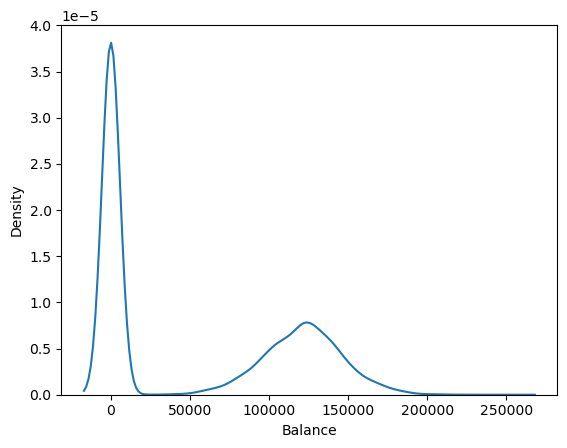

In [7]:
sns.kdeplot(data=df, x='Balance')

c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='EstimatedSalary', ylabel='Density'>

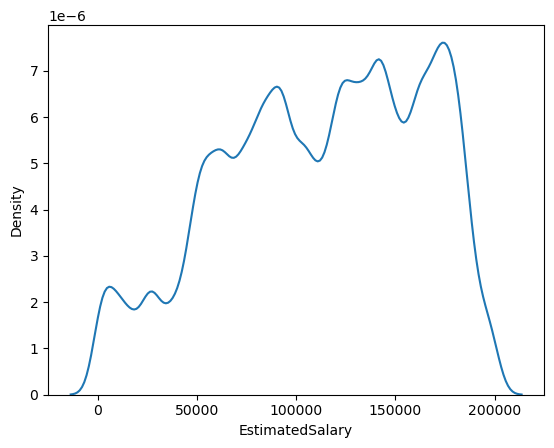

In [8]:
sns.kdeplot(data=df, x='EstimatedSalary')

c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='CreditScore', ylabel='Density'>

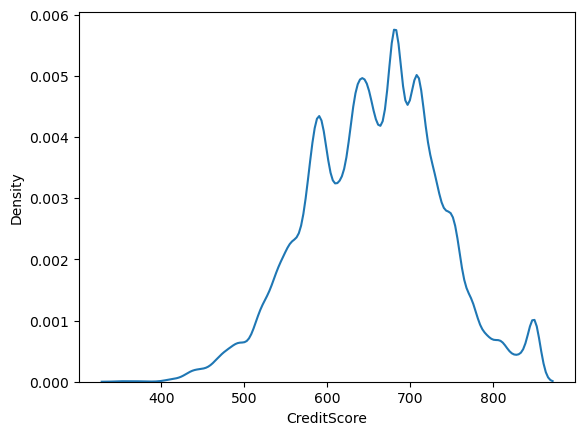

In [9]:
sns.kdeplot(data=df, x='CreditScore')

c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Density'>

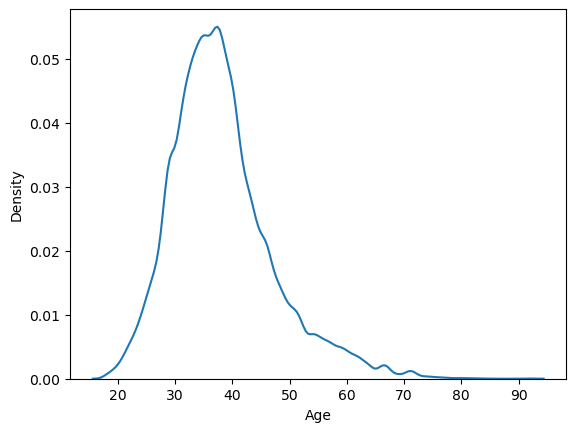

In [10]:
sns.kdeplot(data=df, x='Age')

<Axes: ylabel='Frequency'>

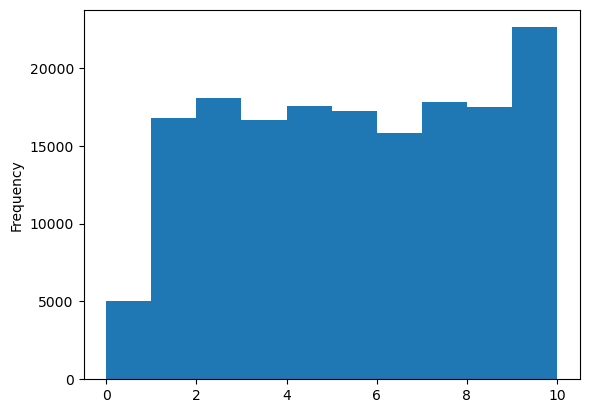

In [11]:
df['Tenure'].plot.hist(bins=10)

### ANOVA Tests

In [12]:
from scipy.stats import f_oneway

def anova_tests(data):
    if df[data].dtype == 'object':
        values = df[data].unique()
        data_for_anova = [df.loc[df[data]==x, 'Exited'] for x in values]
        print(data)
        print(f_oneway(*data_for_anova))
        print()
    
    elif len(df[data].unique()) < 5:
        values = df[data].unique()
        data_for_anova = [df.loc[df[data]==x, 'Exited'] for x in values]
        print(data)
        print(f_oneway(*data_for_anova))
        print()    

    else:
        cut_df = pd.cut(df[data], 5, labels=[0, 1,2,3,4])
        data_for_anova = [df.loc[cut_df==n, 'Exited'] for n in range(5)]
        print(data)
        print(f_oneway(*data_for_anova))      
        print()

In [13]:
for x in ['CreditScore', 'Geography', 'Gender',
          'Age', 'Tenure', 'Balance', 'NumOfProducts',
          'HasCrCard', 'IsActiveMember']:
    anova_tests(x)

CreditScore
F_onewayResult(statistic=56.31199433301987, pvalue=1.500568054485712e-47)

Geography
F_onewayResult(statistic=3850.9807436328238, pvalue=0.0)

Gender
F_onewayResult(statistic=3616.693181457038, pvalue=0.0)

Age
F_onewayResult(statistic=5818.6669417251915, pvalue=0.0)

Tenure
F_onewayResult(statistic=33.27843196929977, pvalue=8.623768939224358e-28)

Balance
F_onewayResult(statistic=855.3927221440127, pvalue=0.0)

NumOfProducts
F_onewayResult(statistic=11791.215114460987, pvalue=0.0)

HasCrCard
F_onewayResult(statistic=80.94474386262738, pvalue=2.3448985511987807e-19)

IsActiveMember
F_onewayResult(statistic=7631.6661912359805, pvalue=0.0)



### Train df

In [14]:
df_test = pd.read_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\kaggle bank chrun\test.csv.zip')

In [15]:
df_test = pd.concat([df_test, pd.get_dummies(df_test['Geography'], dtype=float)], axis=1)
df_test['Gender'] = df_test['Gender'] == 'Male'
df_test['Gender'] = df_test['Gender'].astype(float)

df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain
0,165034,15773898,Lucchese,586,France,0.0,23.0,2,0.00,2,0.0,1.0,160976.75,1.0,0.0,0.0
1,165035,15782418,Nott,683,France,0.0,46.0,2,0.00,1,1.0,0.0,72549.27,1.0,0.0,0.0
2,165036,15807120,K?,656,France,0.0,34.0,7,0.00,2,1.0,0.0,138882.09,1.0,0.0,0.0
3,165037,15808905,O'Donnell,681,France,1.0,36.0,8,0.00,1,1.0,0.0,113931.57,1.0,0.0,0.0
4,165038,15607314,Higgins,752,Germany,1.0,38.0,10,121263.62,1,1.0,0.0,139431.00,0.0,1.0,0.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [17]:
df = pd.concat([df, pd.get_dummies(df['Geography'], dtype=float)], axis=1)
df['Gender'] = df['Gender'] == 'Male'
df['Gender'] = df['Gender'].astype(float)

df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,0,15674932,Okwudilichukwu,668,France,1.0,33.0,3,0.00,2,1.0,0.0,181449.97,0,1.0,0.0,0.0
1,1,15749177,Okwudiliolisa,627,France,1.0,33.0,1,0.00,2,1.0,1.0,49503.50,0,1.0,0.0,0.0
2,2,15694510,Hsueh,678,France,1.0,40.0,10,0.00,2,1.0,0.0,184866.69,0,1.0,0.0,0.0
3,3,15741417,Kao,581,France,1.0,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.0,0.0,0.0
4,4,15766172,Chiemenam,716,Spain,1.0,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.0,0.0,1.0


In [18]:
unwanted = ['id', 'CustomerId', 'Surname', 'Geography', 'Exited']

predictors = [e for e in df.columns.tolist() if e not in unwanted]
predictors

['CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'France',
 'Germany',
 'Spain']

In [19]:
X = df[predictors]
y = df['Exited']

### Naive Bayes

In [20]:
# hyperparameters have been found by the Grid search
# of the cells below.

# naive_model = MultinomialNB(alpha=1000000, fit_prior=True)

# nb_cross = cross_val_score(naive_model, X, y, cv=5)
# nb_cross.mean()

0.5901268716131767

In [21]:
# naive_model = MultinomialNB()
# parameters1= [{'alpha': [10000, 100000, 1000000, 10000000],
#                'fit_prior':[False, True]}]

# Grid1 = GridSearchCV(naive_model, parameters1, cv=5, n_jobs=-1)

# Grid1.fit(X, y)


In [22]:
# Grid1.best_estimator_.get_params()

### Logistic regression

In [23]:
# from sklearn.linear_model import LogisticRegression

# # hyperparameters have been found by the Grid search
# # of the cells below.

# l_reg = LogisticRegression(C=0.25075, fit_intercept=False,
#                            solver='newton-cholesky')

# lr_cross = cross_val_score(l_reg, X, y, cv=5)
# lr_cross.mean()

0.8342341382156764

In [24]:
# param_grid = [{'C' : np.linspace(0.001, 1, 5),
#                'fit_intercept':[True, False],
#                'solver':['lbfgs', 'liblinear', 'newton-cholesky']
#                }]

# lr_grid = GridSearchCV(l_reg, param_grid, cv=4, n_jobs=-1)

# lr_grid.fit(X, y)

# lr_grid.best_estimator_.get_params()

### K-nearest Neighbors

This takes 27 secs

In [25]:
# from sklearn.neighbors import KNeighborsClassifier

# kn_model2 = Pipeline([
#     ('scaler', StandardScaler()), 
#     ('classifier', KNeighborsClassifier(n_neighbors=10))
# ])

# kn_cross2 = cross_val_score(kn_model2, X, y, cv=5, n_jobs=-1)
# kn_cross2.mean()

0.8553025459000019

In [26]:
# I used a PCA so the gridsearch is much faster
# The best param for n_neighbors is > 30. But I decided
# to keep 10 because the difference is minimal

# from sklearn.decomposition import PCA

# X_pca = PCA(0.99).fit_transform(X)

# kn_model2 = Pipeline([
#     ('scaler', StandardScaler()), 
#     ('classifier', KNeighborsClassifier())
# ])

# params = [{'classifier__n_neighbors': [10,12,14,16,20,30]}]

# grid_kn = GridSearchCV(kn_model2, params, cv=3, n_jobs=-1)

# grid_kn.fit(X_pca, y)

# grid_kn.best_estimator_.get_params()

### Classification Trees

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20, random_state=1,)

In [75]:
# from sklearn.tree import DecisionTreeClassifier

# dtc_model = DecisionTreeClassifier(random_state=3, ccp_alpha=4e-5)
# dtc_model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=4.6e-05, random_state=3)

In [76]:
# yhat = dtc_model.predict(x_test)
# metrics.accuracy_score(y_test, yhat)


0.8630896476504983

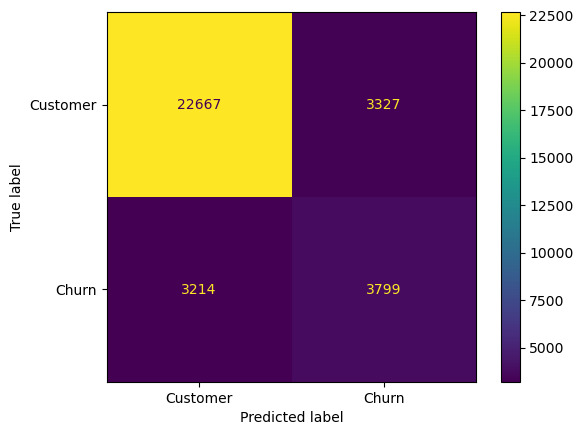

In [77]:
# confusion_matrix = metrics.confusion_matrix(y_test, yhat)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Customer', 'Churn'])

# cm_display.plot()
# plt.show()

<Axes: xlabel='alpha'>

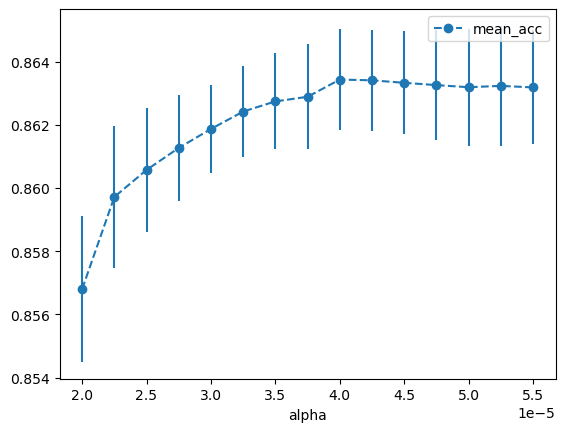

In [78]:
# There are way too many aplhas so I take a few at a time and then go deeper
# After try-and-error attempts I found that 4e-5 is the best value for alpha

# dtc_alphas = np.linspace(2e-5, 5.5e-5, 15)
# result_scores = []

# for alpha in dtc_alphas:
#     tree = DecisionTreeClassifier(random_state=3, ccp_alpha=alpha)
#     scores = cross_val_score(tree, X, y, cv=5)
#     result_scores.append([alpha, np.mean(scores), np.std(scores)])

# result_scores_df = pd.DataFrame(result_scores,
#                                 columns=['alpha', 'mean_acc', 'std'])

# result_scores_df.plot(x='alpha', y='mean_acc',
#                       yerr='std', marker='o', linestyle='--')

In [80]:
# tree = DecisionTreeClassifier(random_state=3, ccp_alpha=4e-5)
# cross_val_score(tree, X, y, cv=5).mean()

0.8634341982228889

### Random forest

In [120]:
# # This grid search is the result of a LOT of try and error
# # with small_x and small_y so to 10x the process

# small_x = x_train.sample(frac=0.1)
# small_y = y_train.sample(frac=0.1)

# params = {
#     'max_depth': [50],
#     'min_samples_leaf': [2],
#     'n_estimators': [50,100],
#     'ccp_alpha': [3.4e-5],
#     'warm_start':[False],
#     'max_features':['sqrt']
# }

# rf_grid = GridSearchCV(estimator=RandomForestClassifier(),
#                        param_grid=params, cv=3, n_jobs=-1, verbose=1)

# rf_grid.fit(small_x, small_y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [3.4e-05], 'max_depth': [50, 100],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2],
                         'n_estimators': [50, 100], 'warm_start': [False]},
             verbose=1)

In [124]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=50,
                            n_estimators=50, oob_score=True, ccp_alpha= 3.4e-05,
                            min_samples_leaf=2)
rf.fit(x_train, y_train)

cross_val_score(rf, X, y, cv=4).mean()

0.8642885631096964

In [125]:
imp_df = pd.DataFrame({
    "Varname": X.columns,
    "Imp": rf.feature_importances_
})

imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
2,Age,0.356886
5,NumOfProducts,0.310706
7,IsActiveMember,0.097775
4,Balance,0.070233
10,Germany,0.053436
1,Gender,0.033561
8,EstimatedSalary,0.025163
0,CreditScore,0.023800
9,France,0.011959
3,Tenure,0.008989
